In [10]:
# Analyze hmc samples produced by SLURM job.
# Author Peter Oct 28 2021
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import utils
import glob
import os

def process_samples(sample_files):
    if type(sample_files) is not list:
        sample_files = [sample_files]
    # Concatenate all files together. These are from different initializations. 
    temp = [np.loadtxt(f, delimiter=',') for f in sample_files]
    temp = [d for d in temp if d.ndim==2]
    samples = np.concatenate(temp, axis=0)
    # Remove outliers.
    num_orig = samples.shape[0]
    samples = utils.remove_outliers(samples, buffer=1.)
    print(f'Found {samples.shape[0]} samples after removing {num_orig - samples.shape[0]} outliers.')
    return samples

In [17]:
# Load results from distributed job, then save processed samples to file. 
#expname = 'AMS02_H-PRL2018' # 'AMS02_H-PRL2018', 'AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018'
job2exp = {41085257: 'AMS02_H-PRL2018',
          }
jobid =  41085257 #29277439 
expname = job2exp[jobid]
filename_heliosphere = f'../data/oct2022/{expname}_heliosphere.dat'

sample_files = glob.glob(f'../../results/job_{jobid}/samples_*.csv')
for f in sample_files:
    SLURM_ARRAY_TASK_ID = int(os.path.splitext(os.path.basename(f))[0].split('_')[1]) # Index of interval. 
    interval = utils.get_interval(filename_heliosphere, SLURM_ARRAY_TASK_ID) # e.g. '20110520-20110610'
    
    samples = process_samples(f)
    
    # Claudio said 1e5 should be enough. Use the last ones for extra burn-in. 
    samples = samples[-100000:, :]
    
    # Save samples to file for Claudio. 
    np.savetxt(fname=f'./for_claudio/samples_{expname}_{interval}.csv', X=samples, fmt='%.8e')
    

Found 488513 samples after removing 0 outliers.


In [16]:
samples.shape

(100000, 5)

# Visualization

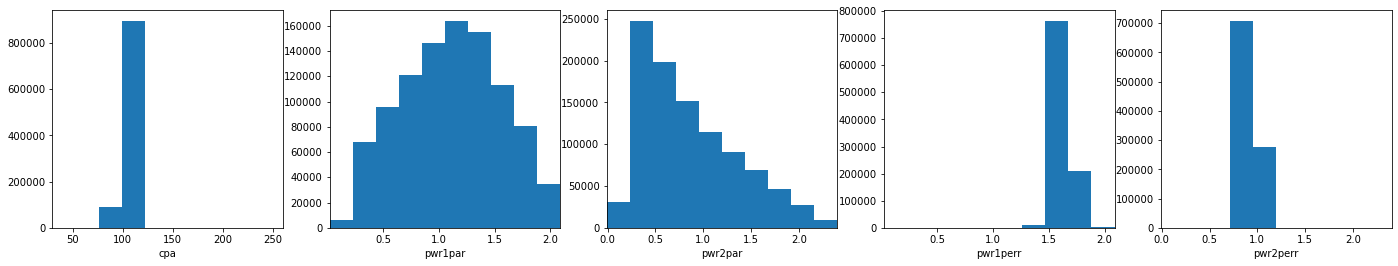

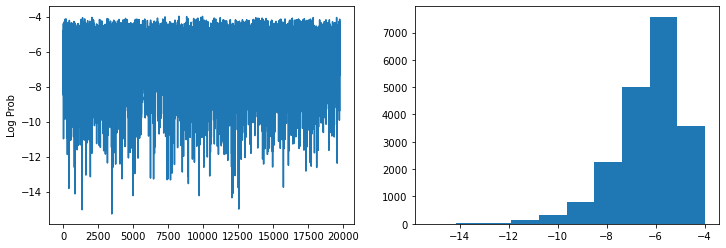

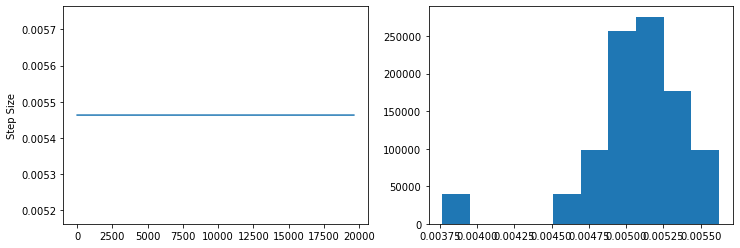

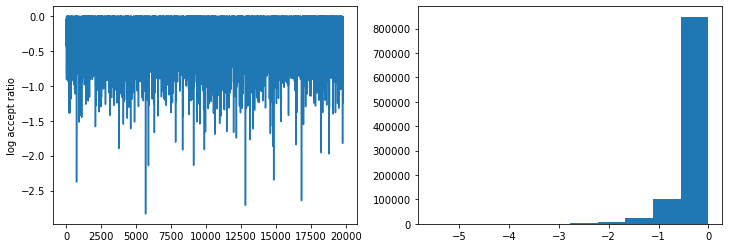

In [3]:
# Plot marginals.
plt.figure(1, figsize=(24, 4))
for i in range(samples.shape[1]):
    minmax = (utils.MIN_PARAMETERS[i] - .1*utils.RANGE_PARAMETERS[i], 
              utils.MAX_PARAMETERS[i] + 0.05*utils.RANGE_PARAMETERS[i])
    plt.subplot(1, samples.shape[1], i+1)
    plt.hist(samples[:, i], bins=10, range=minmax)
    plt.xlabel(utils.PARAMETERS[i])
    plt.xlim(minmax)
#plt.savefig(fname=f'{results_dir}/marginals_{unique_id}.pdf', bbox_inches='tight')

plt.figure(2, figsize=(12, 4))
x = np.loadtxt(glob(f'../../results/job_{jobid}/log_probs_*.csv')[0])
plt.subplot(1,2,1)
plt.plot(x)
plt.ylabel("Log Prob")
plt.subplot(1,2,2)
plt.hist(x)

plt.figure(3, figsize=(12, 4))
x = np.loadtxt(glob(f'../../results/job_{jobid}/stepsizes_*.csv')[0])
plt.subplot(1,2,1)
plt.plot(x)
plt.ylabel("Step Size")
plt.subplot(1,2,2)
x = np.concatenate([np.loadtxt(d) for d in glob(f'../../results/job_{jobid}/stepsizes_*.csv')], axis=0)
plt.hist(x)

plt.figure(4, figsize=(12, 4))
x = np.loadtxt(glob(f'../../results/job_{jobid}/logacceptratio_*.csv')[0])
plt.subplot(1,2,1)
plt.plot(x)
plt.ylabel("log accept ratio")
plt.subplot(1,2,2)
x = np.concatenate([np.loadtxt(d) for d in glob(f'../../results/job_{jobid}/logacceptratio_*.csv')], axis=0)
plt.hist(x)
print()

# Plot Marginals

(array([50. ,  0.2,  0.2,  0.2,  0.2]),
 array([250. ,   2. ,   2.3,   2. ,   2.3]),
 array([85.62527895,  0.20000129,  0.20000098,  1.33448976,  0.72615676]),
 array([128.14437151,   1.99997908,   2.29995168,   1.99542522,
          1.15037301]))

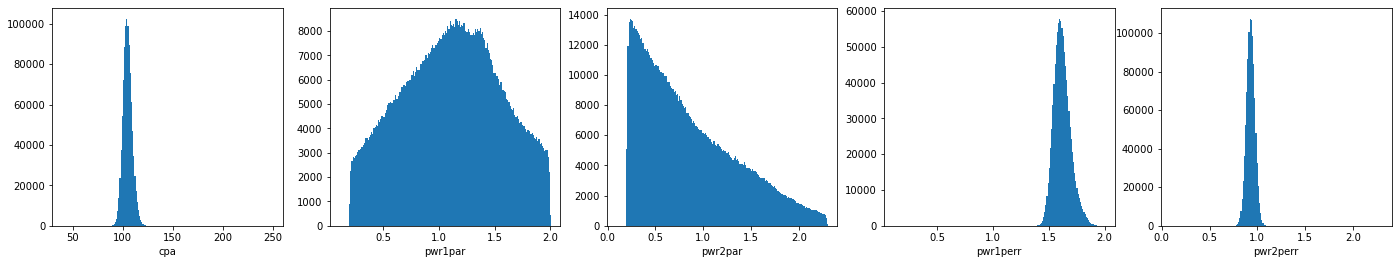

In [13]:
# Plot marginals.
plt.figure(1, figsize=(24, 4))
for i in range(samples.shape[1]):
    minmax = (MIN[i] - .1*RANGE[i], MAX[i] + 0.05*RANGE[i])
    plt.subplot(1, samples.shape[1], i+1)
    plt.hist(samples[:, i], bins=200, range=minmax)
    plt.xlabel(parameter_names[i])
    plt.xlim(minmax)
plt.savefig(fname=f'results/job_{jobid}/marginals.pdf', bbox_inches='tight')
MIN, MAX, samples.min(axis=0), samples.max(axis=0)

# Plot step size distribution

(array([ 2.,  0.,  0.,  0.,  2.,  5., 13., 14.,  9.,  5.]),
 array([0.0037676 , 0.00395322, 0.00413884, 0.00432447, 0.00451009,
        0.00469572, 0.00488134, 0.00506697, 0.00525259, 0.00543821,
        0.00562384]),
 <BarContainer object of 10 artists>)

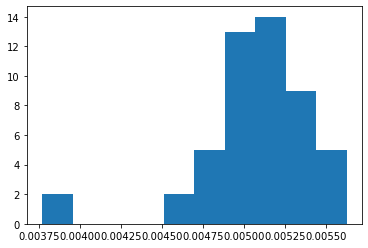

In [21]:
filenames = glob(f'../../results/job_{jobid}/stepsizes_*.csv')
sizes= []
for f in filenames:
    sizes.append(np.loadtxt(f)[0])
sizes = np.array(sizes)
plt.hist(sizes)
sizes.min(), sizes.max()

# Analyze auto correlation 

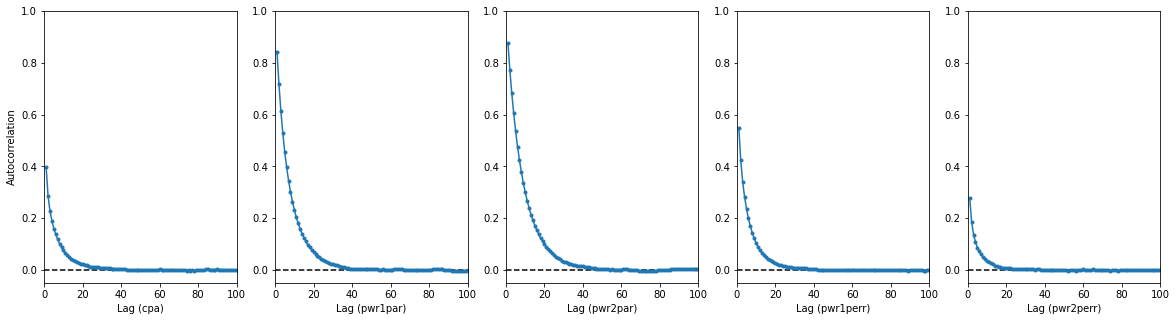

In [111]:
# See https://www.statlect.com/fundamentals-of-statistics/autocorrelation
import gcr_utils
import importlib
importlib.reload(gcr_utils)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf#, acovf

max_lag = 100

plt.figure(1, figsize=(20,5))
for i in range(5):
    ax = plt.subplot(1,5,i+1)
    #plot_acf(samples[:100000, i], lags=range(1,100), alpha=None,title='', ax=ax, use_vlines=False)
    x = acf(samples[:, i], nlags=max_lag)
    plt.plot(range(1, max_lag+1), x[1:], marker='.')
    plt.ylim([-.05, 1])
    plt.xlim([0, max_lag])
    plt.hlines(y=0, xmin=0, xmax=max_lag, linestyles='--', color='k')
    plt.xlabel(f'Lag ({parameter_names[i]})')
    if i==0:
        plt.ylabel('Autocorrelation')
plt.savefig(f'autocorrelation.pdf', bbox_inches='tight')